# Reward Estimation: Comparison

In this notebook, we compare different reward estimation algorithms.

In [1]:
import copy
import pathlib
import os
import os.path
from typing import Sequence
import itertools

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from scipy import stats
import ray
import ray.data

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
import warnings # To suppress some warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [5]:
from drmdp.workflows import rewest

## Data Proc

In [6]:
def load_data(paths: Sequence[str]):
    records = []
    for path in paths:
        records.extend(rewest.read_records(path))
    return pd.DataFrame(records)

In [7]:
def rmse(v_pred: np.ndarray, v_true: np.ndarray, axis: int):
    if np.shape(v_pred) != np.shape(v_true):
        raise ValueError(
            f"Tensors have different shapes: {np.shape(v_pred)} != {np.shape(v_true)}"
        )
    delta = v_pred - v_true
    sq = delta * delta
    sqsum = np.sum(sq, axis=axis) / np.shape(v_pred)[axis]
    sqsqrt = np.sqrt(sqsum)
    return sqsqrt

In [8]:
def parse_feats_spec_shortened(feats_spec):
    name = feats_spec["name"]
    if feats_spec["args"] is not None:
        kwargs = feats_spec["args"]
        # first char, value
        values = [f"{key[0]}:{str(value)}" for key, value in sorted(kwargs.items())]
        suffix = "/".join(values)
    else:
        suffix = "-"
    return f"{name}({suffix})"

In [9]:
def process_results(df_input):
    # averane at each poit in time
    def control_type(name: str):
        if "-TC-" in name:
            return "Torque"
        elif "-CC-" in name:
            return "Current"
        elif "-SC-" in name:
            return "Speed"
        return "Classic"

    def parse_bias(meta):
        return "Yes" if meta["use_bias"] else "No"

    def parse_rmse(meta):
        error = meta.get("error", None) or {"rmse": np.nan}
        return error["rmse"]

    def rename(env):
        return env.lstrip("Finite-")

    def parse_env_version(env_args):
        es = env_args.get("emit_state", None)
        # Is present and true
        if es:
            return "(ES)"
        return ""
        

    df_out = copy.deepcopy(df_input)
    df_out["control_feats_spec"] = df_out["control_feats_spec"].apply(parse_feats_spec_shortened)
    df_out["control_type"] = df_out["env_name"].apply(control_type)
    df_out["env_name"] = df_out["env_name"].apply(rename)
    df_out["env_name"] = df_out["env_name"] + df_out["env_args"].apply(parse_env_version)

    for key in ("returns", "solver_state", "all_steps_error", "post_est_error"):
        df_out[key] = df_out["meta"].apply(lambda meta: meta[key])

    df_out["bias"] = df_out["meta"].apply(parse_bias)
    df_out["rmse"] = df_out["meta"].apply(parse_rmse)
    df_out = df_out.drop(["meta"], axis=1)

    # Separate problems that had solutions before
    # the final episode
    solution_step = df_out["solver_state"].apply(
        lambda state: state["solution_found_step"]
    )
    df_est, df_no_est = copy.copy(df_out[~pd.isna(solution_step)]), df_out[pd.isna(solution_step)]
    return df_est, df_no_est

In [10]:
%%time
df_proc_result, df_no_est = process_results(
    df_input=load_data(
        tf.io.gfile.glob(os.path.join(pathlib.Path.home(), "fs/drmdp/exp/rewest/1762372707/*.jsonl.gzip"))
    )
)

CPU times: user 4.11 s, sys: 727 ms, total: 4.83 s
Wall time: 5.52 s


In [11]:
df_no_est

,task_id,env_name,env_args,control_feats_spec,rewest_method,rewest_args,reward_delay,num_episodes,use_bias,epochs,turn,control_type,returns,solver_state,all_steps_error,post_est_error,bias,rmse


In [12]:
if len(df_no_est) > 0:
    print(df_no_est["env_name"].unique())

In [13]:
df_no_est["rewest_method"].unique()

array([], dtype=object)

In [14]:
df_proc_result

,task_id,env_name,env_args,control_feats_spec,rewest_method,rewest_args,reward_delay,num_episodes,use_bias,epochs,turn,control_type,returns,solver_state,all_steps_error,post_est_error,bias,rmse
0,96f79801-06e2-4a08-8b37-38335ce43073,TC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",tiles(t:3),least-lfa,"{'attempt_estimation_episode': 50, 'feats_spec...",6,1000,False,1,1,Torque,307.532973,{'solution_found_step': 5880},2.055471,1.812608e-15,No,1.000227e-14
1,7d9faf3e-8ff2-44d6-844e-c5dab3628601,SC-ShuntDc-v0(ES),"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",scale(-),least-lfa,"{'attempt_estimation_episode': 50, 'feats_spec...",4,1000,False,1,5,Speed,208.117394,{'solution_found_step': 431},0.410989,3.137986e-11,No,1.246662e-14
2,1ebe67da-6eb7-4e98-a15b-47f3b0f58dfa,SC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",scale(-),bayes-least-lfa,"{'init_attempt_estimation_episode': 10, 'mode'...",2,1000,False,1,17,Speed,147.629250,{'solution_found_step': 6795},1.086086,1.753558e-02,No,3.273310e-02
3,3a664fe7-b6a6-403b-b8b3-23d82f29f9a0,TC-PermExDc-v0(ES),"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",scale(-),bayes-least-lfa,"{'init_attempt_estimation_episode': 10, 'mode'...",2,1000,False,1,10,Torque,125.928602,{'solution_found_step': 111},0.145158,3.456333e-04,No,4.212144e-13
4,76e4f149-01cd-4ba8-bef0-fd338c90f820,SC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",tiles(t:6),least-lfa,"{'attempt_estimation_episode': 50, 'feats_spec...",2,1000,False,1,16,Speed,179.536387,{'solution_found_step': 7088},1.166320,2.337970e-15,No,3.281155e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,c767c16d-36c5-4505-89ca-ac425c2da8a4,CC-ShuntDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",tiles(t:3),bayes-least-lfa,"{'init_attempt_estimation_episode': 10, 'mode'...",2,1000,False,1,8,Current,361.209302,{'solution_found_step': 6518},1.225734,1.872566e-02,No,7.921156e-03
18716,24fce4a3-d045-411c-aaa7-42cd4763db8e,CC-PermExDc-v0,"{'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...",spliced-tiles(t:4),least-lfa,"{'attempt_estimation_episode': 50, 'feats_spec...",4,1000,False,1,15,Current,314.175926,{'solution_found_step': 10646},2.236522,2.704230e-02,No,3.228359e-03
18717,1a3d1a7d-e220-47a4-96fc-4e0f7801ac7f,GridWorld-v0,"{'grid': ['ooooxooooooo', 'oooooooooxoo', 'oxo...",tiles(t:8),discrete-least-lfa,"{'attempt_estimation_episode': 50, 'feats_spec...",2,1000,False,5,2,Classic,-109.851400,{'solution_found_step': 9978},10.974334,1.413813e+00,No,8.390100e-14
18718,577e2b15-b5b8-4ee3-84e1-73ae9acad34f,GridWorld-v0,"{'grid': ['ooooxooooooo', 'oooooooooxoo', 'oxo...",tiles(t:8),least-lfa,"{'attempt_estimation_episode': 50, 'feats_spec...",4,1000,False,5,17,Classic,-110.198600,{'solution_found_step': 10600},13.365381,8.561939e-02,No,1.076091e-13


In [15]:
sorted(df_proc_result["control_type"].unique())

['Classic', 'Current', 'Speed', 'Torque']

In [16]:
sorted(df_proc_result["env_name"].unique())

['CC-PermExDc-v0',
 'CC-PermExDc-v0(ES)',
 'CC-ShuntDc-v0',
 'CC-ShuntDc-v0(ES)',
 'GridWorld-v0',
 'IceWorld-v0',
 'SC-PermExDc-v0',
 'SC-PermExDc-v0(ES)',
 'SC-ShuntDc-v0',
 'SC-ShuntDc-v0(ES)',
 'TC-PermExDc-v0',
 'TC-PermExDc-v0(ES)']

In [17]:
df_proc_result.iloc[0]["rewest_args"]

{'attempt_estimation_episode': 50,
 'feats_spec': {'name': 'scale', 'args': None},
 'estimation_buffer_mult': 25}

In [18]:
METHOD_PALLETE = {
    key: palette for key, palette in zip(
        sorted(df_proc_result["rewest_method"].unique()),
        sns.color_palette()
    )
}

## Config Success Rate

In [19]:
def get_env_method_configs(df_input):
    df_slice = copy.copy(df_input[["env_name", "rewest_method", "reward_delay", "rewest_args"]])
    df_slice["rewest_args"] = df_slice["rewest_args"].apply(
        lambda config: tuple([(key, str(value)) for key, value in sorted(config.items())])
    )
    return df_slice

In [20]:
get_env_method_configs(df_no_est).value_counts()

Series([], Name: count, dtype: int64)

In [21]:
df_failed = get_env_method_configs(df_no_est)
df_completed = get_env_method_configs(df_proc_result)

In [22]:
df_failed["rewest_args"].explode().value_counts()

Series([], Name: count, dtype: int64)

Failure cases:

  - Specs using tiling (instead of Scaling) for GEM environments

In [23]:
df_completed["rewest_args"].explode().value_counts().to_dict()

{('attempt_estimation_episode', '50'): 13320,
 ('feats_spec', "{'name': 'scale', 'args': None}"): 6480,
 ('estimation_buffer_mult', '25'): 6240,
 ('estimation_buffer_mult', '10'): 6240,
 ('estimation_buffer_mult', 'None'): 6240,
 ('init_attempt_estimation_episode', '10'): 5400,
 ('mode', 'double'): 5400,
 ('constraints_buffer_limit', '100'): 5400,
 ('feats_spec', "{'name': 'tiles', 'args': {'tiling_dim': 6}}"): 4860,
 ('feats_spec', "{'name': 'tiles', 'args': {'tiling_dim': 3}}"): 3780,
 ('feats_spec', "{'name': 'cluster-c', 'args': {'num_clusters': 100}}"): 2160,
 ('feats_spec', "{'name': 'tiles', 'args': {'tiling_dim': 8}}"): 540,
 ('feats_spec', "{'name': 'tiles', 'args': {'tiling_dim': 7}}"): 540,
 ('feats_spec', "{'name': 'flat-grid-coord', 'args': None}"): 360}

In [24]:
def config_arg_success_rate(df_succ, df_fail):
    envs = set(np.concatenate([df_succ["env_name"].unique(), df_fail["env_name"].unique()]))
    config_rows = []
    arg_rows = []
    for env in envs:
        succ_configs = df_succ[df_succ["env_name"] == env]["rewest_args"].value_counts().to_dict()
        fail_configs = df_fail[df_fail["env_name"] == env]["rewest_args"].value_counts().to_dict()        
        for config in set(tuple(succ_configs.keys()) + tuple(fail_configs.keys())):
            succ = succ_configs.get(config, 0)
            fail = fail_configs.get(config, 0)
            config_rows.append({
                "env_name": env,
                "config": config,
                "success": succ,
                "success_rate": succ / (succ + fail)
            })
        
        succ_args = df_succ[df_succ["env_name"] == env]["rewest_args"].explode().value_counts().to_dict()
        fail_args = df_fail[df_fail["env_name"] == env]["rewest_args"].explode().value_counts().to_dict()
        for arg in set(tuple(succ_args.keys()) + tuple(fail_args.keys())):
            succ = succ_args.get(arg, 0)
            fail = fail_args.get(arg, 0)
            arg_rows.append({
                "env_name": env,
                "arg": arg,
                "success": succ,
                "success_rate": succ / (succ + fail)
            })
    return pd.DataFrame(config_rows), pd.DataFrame(arg_rows)

In [25]:
df_config_success_rate, df_arg_success_rate = config_arg_success_rate(df_completed, df_failed)

In [26]:
df_config_success_rate[df_config_success_rate["success_rate"] < 1.0]

,env_name,config,success,success_rate


In [27]:
df_arg_success_rate[df_arg_success_rate["success_rate"] < 1.0]

,env_name,arg,success,success_rate


In [28]:
get_env_method_configs(df_proc_result).value_counts()

env_name            rewest_method    reward_delay  rewest_args                                                                                                                                        
SC-ShuntDc-v0       least-lfa        2             ((attempt_estimation_episode, 50), (estimation_buffer_mult, 10), (feats_spec, {'name': 'scale', 'args': None}))                                        60
                                     6             ((attempt_estimation_episode, 50), (estimation_buffer_mult, 10), (feats_spec, {'name': 'tiles', 'args': {'tiling_dim': 6}}))                           60
                    bayes-least-lfa  6             ((estimation_buffer_mult, 25), (feats_spec, {'name': 'tiles', 'args': {'tiling_dim': 6}}), (init_attempt_estimation_episode, 10), (mode, double))      60
                                                   ((estimation_buffer_mult, None), (feats_spec, {'name': 'scale', 'args': None}), (init_attempt_estimation_episode, 10), (mode, double)) 

## Fixed Sample Estimation Methods

In [29]:
def export_figure(
    figure, name: str, format: str = "pdf", dpi=300, transparent: bool = True
):
    # to be able to save, we must plot
    base_dir = os.path.dirname(name)
    if not os.path.exists(base_dir):
        tf.io.gfile.makedirs(base_dir)
    
    figure.savefig(f"{name}.{format}", dpi=dpi, format=format, transparent=transparent)

## Outcome Metrics

In [30]:
def calc_ci(xs, confidence: float, method: str = "auto"):
    if method not in ("auto", "t-distribution", "normal"):
        raise ValueError("Method must be one of: {auto, t-distribution, normal}")

    # calculate mean 
    mean = np.mean(xs)
    # standard error
    std_err = stats.sem(xs)

    if (method == "auto" and len(xs) < 30) or method == "t-distribution":
        form = "t-distribution"
        lb, ub = stats.t.interval(confidence=confidence, df=len(xs)-1, loc=mean, scale=std_err)
    else:
        form = "normal"
        lb, ub = stats.norm.interval(confidence=confidence, loc=mean, scale=std_err)

    ci = np.abs(ub - mean)
    return {"ub": ub, "lb": lb, "mean": mean, "ci": ci, "ci_method": form}

In [31]:
def shortern_estimator_args(args):
    relevant = set(["estimation_sample_size", "init_update_episodes"])
    proc_args = []
    for key, value in sorted(args.items()):
        if key not in relevant:
            continue
        short_key = "".join([word[0] for word in key.split("_")])
        proc_args.append(
            f"{short_key}={value}"
        )
    return tuple(proc_args)

### Returns: Across Configs

In [32]:
def calc_algo_metric_ci(df_results: pd.DataFrame, metric_name: str, confidence: float, decimals: int = 4) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    envs = sorted(df_results["env_name"].unique())
    methods = sorted(df_results["rewest_method"].unique())
    
    rows = []
    for env, method in itertools.product(envs, methods):
        df_slice = copy.copy(
            df_results[
                (df_results["env_name"] == env) &
                (df_results["rewest_method"] == method)
            ]
        )
        errors = df_slice[metric_name].values
        errors = errors[~np.isnan(errors)]
        if len(errors) == 0:
            print(env, method, df_slice[metric_name].values)
            errors = [np.nan]
        ci_result = calc_ci(errors, confidence=confidence, method="auto")
        ci_fmt = " ± ".join([
            str(np.around(ci_result["mean"], decimals)),
            str(np.around(ci_result["ci"], decimals)),
        ])
        row = {
            "env_name": env,
            "rewest_method": method,
            "ci_fmt": ci_fmt,
            **ci_result
        }
        rows.append(row)
    return pd.DataFrame(rows).sort_values(["env_name", "rewest_method"])

In [33]:
df_algo_returns_ci = calc_algo_metric_ci(df_proc_result, metric_name="returns", confidence=0.95)

In [34]:
df_algo_returns_ci

,env_name,rewest_method,ci_fmt,ub,lb,mean,ci,ci_method
0,CC-PermExDc-v0,bayes-least-lfa,316.6248 ± 1.9426,318.567425,314.682161,316.624793,1.942632,normal
1,CC-PermExDc-v0,cvlps,318.0776 ± 2.1491,320.226698,315.928562,318.077630,2.149068,normal
2,CC-PermExDc-v0,discrete-least-lfa,323.4485 ± 5.2182,328.666671,318.230330,323.448500,5.218170,normal
3,CC-PermExDc-v0,least-lfa,318.2136 ± 2.1843,320.397914,316.029251,318.213583,2.184332,normal
4,CC-PermExDc-v0(ES),bayes-least-lfa,153.9539 ± 5.8746,159.828461,148.079331,153.953896,5.874565,normal
5,CC-PermExDc-v0(ES),cvlps,148.1017 ± 6.1279,154.229670,141.973775,148.101722,6.127948,normal
6,CC-PermExDc-v0(ES),discrete-least-lfa,194.0447 ± 10.0917,204.136383,183.953074,194.044728,10.091655,normal
7,CC-PermExDc-v0(ES),least-lfa,152.3512 ± 6.2066,158.557878,146.144603,152.351240,6.206638,normal
8,CC-ShuntDc-v0,bayes-least-lfa,370.5063 ± 0.4578,370.964082,370.048431,370.506257,0.457825,normal
9,CC-ShuntDc-v0,cvlps,369.8776 ± 0.5261,370.403695,369.351590,369.877642,0.526053,normal


In [35]:
df_algo_returns_ci.pivot(columns="rewest_method", index="env_name", values="ci_fmt")

rewest_method,bayes-least-lfa,cvlps,discrete-least-lfa,least-lfa
env_name,,,,
CC-PermExDc-v0,316.6248 ± 1.9426,318.0776 ± 2.1491,323.4485 ± 5.2182,318.2136 ± 2.1843
CC-PermExDc-v0(ES),153.9539 ± 5.8746,148.1017 ± 6.1279,194.0447 ± 10.0917,152.3512 ± 6.2066
CC-ShuntDc-v0,370.5063 ± 0.4578,369.8776 ± 0.5261,367.4208 ± 1.6557,370.2935 ± 0.4927
CC-ShuntDc-v0(ES),263.3991 ± 3.7849,269.1723 ± 3.643,274.8515 ± 4.2761,268.72 ± 3.8101
GridWorld-v0,-108.4792 ± 0.2347,-117.4804 ± 2.0243,-138.9342 ± 12.6441,-107.7316 ± 0.3963
IceWorld-v0,-60.1695 ± 1.0298,-140.7859 ± 5.059,-150.1045 ± 3.3139,-79.3855 ± 3.9092
SC-PermExDc-v0,223.9341 ± 0.4316,222.0785 ± 1.2935,219.2274 ± 1.5725,224.1344 ± 0.3872
SC-PermExDc-v0(ES),260.2775 ± 4.9977,260.7883 ± 5.19,262.7132 ± 6.454,258.6027 ± 5.0288
SC-ShuntDc-v0,188.8166 ± 2.3406,186.3491 ± 2.3729,181.2418 ± 5.145,189.7614 ± 2.3768


Overall, across reward estimation configs, buffer sizes, and delays:
  - `cvlps` and `least` are equivalent in performance; some times better;
  - `discrete-least-lfa` is sometimes as good as, sometime worse than both `cvlps` and `least-lfa`
  - `bayes-least-lfa` is consistently better than all other methods, and has substantial gains in `GridWorld`

## Returns per Config

In [36]:
def est_encodings_and_buffer(df_input: pd.DataFrame):
    def parse_buffer_multiple(rewest_args) -> str:
        value = rewest_args["estimation_buffer_mult"]
        return f"BM={int(value):02d}" if value else "BM=None"
        
    def parse_rewest_feats_spec(rewest_args) -> str:
        return parse_feats_spec_shortened(rewest_args["feats_spec"])

    def algorithm_type(method: str) -> str:
        if "bayes" in method:
            return "bayes"
        return "fixed"

    df_slice = copy.copy(
        df_input[["env_name", "rewest_method", "rewest_args", "reward_delay", "control_type", "returns"]]
    )
    df_slice["rewest_buffer_mult"] = df_slice["rewest_args"].apply(parse_buffer_multiple)
    df_slice["rewest_feats_spec"] = df_slice["rewest_args"].apply(parse_rewest_feats_spec)
    df_slice["rewest_est_type"] = df_slice["rewest_method"].apply(algorithm_type)
    
    del df_slice["rewest_args"]
    return df_slice

In [37]:
df_est_encodings_and_buffer = est_encodings_and_buffer(df_proc_result)

In [38]:
df_est_encodings_and_buffer

,env_name,rewest_method,reward_delay,control_type,returns,rewest_buffer_mult,rewest_feats_spec,rewest_est_type
0,TC-PermExDc-v0,least-lfa,6,Torque,307.532973,BM=25,scale(-),fixed
1,SC-ShuntDc-v0(ES),least-lfa,4,Speed,208.117394,BM=25,scale(-),fixed
2,SC-ShuntDc-v0,bayes-least-lfa,2,Speed,147.629250,BM=10,tiles(t:3),bayes
3,TC-PermExDc-v0(ES),bayes-least-lfa,2,Torque,125.928602,BM=10,scale(-),bayes
4,SC-ShuntDc-v0,least-lfa,2,Speed,179.536387,BM=10,scale(-),fixed
...,...,...,...,...,...,...,...,...
18715,CC-ShuntDc-v0,bayes-least-lfa,2,Current,361.209302,BM=25,tiles(t:3),bayes
18716,CC-PermExDc-v0,least-lfa,4,Current,314.175926,BM=10,tiles(t:6),fixed
18717,GridWorld-v0,discrete-least-lfa,2,Classic,-109.851400,BM=10,flat-grid-coord(-),fixed
18718,GridWorld-v0,least-lfa,4,Classic,-110.198600,BM=25,tiles(t:8),fixed


### Returns: Config Ranking

In [39]:
def calc_algo_config_metric_ci(df_input: pd.DataFrame, metric_name: str, confidence: float, decimals: int = 4) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    df_ref = copy.copy(df_input)
    envs = sorted(df_ref["env_name"].unique())
    algorithms = sorted(df_ref["rewest_method"].unique())    
    df_ref["config"] = df_ref["rewest_buffer_mult"] + "::" + df_ref["rewest_feats_spec"]

    rows = []
    for env, algorithm in itertools.product(envs, algorithms):
        df_env_algo = copy.copy(
            df_ref[
                (df_ref["env_name"] == env) &
                (df_ref["rewest_method"] == algorithm)
            ]
        )

        configs = df_env_algo["config"].unique()
        config_entries = []
        for config in configs:
            df_config = df_env_algo[df_env_algo["config"] == config]   
            errors = df_config[metric_name].values
            errors = errors[~np.isnan(errors)]
            ci_result = calc_ci(errors, confidence=confidence, method="auto")
            ci_fmt = " ± ".join([
                str(np.around(ci_result["mean"], decimals)),
                str(np.around(ci_result["ci"], decimals)),
            ])
        
            row = {
                "env_name": env,
                "rewest_method": algorithm,
                "ci_fmt": ci_fmt,
                "config": config,
                **ci_result
            }
            config_entries.append(row)

        means = np.array([entry["mean"] for entry in config_entries])
        ranking = np.argsort(means)
        rows.extend([config_entries[idx] for idx in reversed(ranking)])
    return pd.DataFrame(rows).sort_values(["env_name", "rewest_method"])

In [40]:
df_algo_config_metric_ci = calc_algo_config_metric_ci(
    df_est_encodings_and_buffer, metric_name="returns", confidence=0.95
)

In [41]:
df_algo_config_metric_ci

,env_name,rewest_method,ci_fmt,config,ub,lb,mean,ci,ci_method
0,CC-PermExDc-v0,bayes-least-lfa,320.8356 ± 5.1737,BM=25::scale(-),326.009282,315.661976,320.835629,5.173653,normal
1,CC-PermExDc-v0,bayes-least-lfa,320.1489 ± 5.6749,BM=25::tiles(t:6),325.823871,314.474020,320.148945,5.674926,normal
2,CC-PermExDc-v0,bayes-least-lfa,317.7711 ± 6.0023,BM=None::tiles(t:3),323.773354,311.768843,317.771098,6.002256,normal
3,CC-PermExDc-v0,bayes-least-lfa,317.2521 ± 5.282,BM=10::tiles(t:6),322.534143,311.970116,317.252130,5.282013,normal
4,CC-PermExDc-v0,bayes-least-lfa,316.1982 ± 6.1866,BM=10::tiles(t:3),322.384856,310.011624,316.198240,6.186616,normal
...,...,...,...,...,...,...,...,...,...
247,TC-PermExDc-v0(ES),discrete-least-lfa,206.9274 ± 17.2305,BM=10::cluster-c(n:100),224.157885,189.696941,206.927413,17.230472,normal
248,TC-PermExDc-v0(ES),discrete-least-lfa,190.1405 ± 17.4606,BM=25::cluster-c(n:100),207.601097,172.679929,190.140513,17.460584,normal
249,TC-PermExDc-v0(ES),least-lfa,157.7719 ± 10.9157,BM=10::scale(-),168.687578,146.856127,157.771853,10.915726,normal
250,TC-PermExDc-v0(ES),least-lfa,156.3571 ± 10.9555,BM=None::scale(-),167.312614,145.401680,156.357147,10.955467,normal


In [42]:
def print_env_method_ranking(df_input, env_name: str):
    return df_input[df_input["env_name"] == env_name]

In [43]:
print_env_method_ranking(df_algo_config_metric_ci, "CC-PermExDc-v0")

,env_name,rewest_method,ci_fmt,config,ub,lb,mean,ci,ci_method
0,CC-PermExDc-v0,bayes-least-lfa,320.8356 ± 5.1737,BM=25::scale(-),326.009282,315.661976,320.835629,5.173653,normal
1,CC-PermExDc-v0,bayes-least-lfa,320.1489 ± 5.6749,BM=25::tiles(t:6),325.823871,314.474020,320.148945,5.674926,normal
2,CC-PermExDc-v0,bayes-least-lfa,317.7711 ± 6.0023,BM=None::tiles(t:3),323.773354,311.768843,317.771098,6.002256,normal
3,CC-PermExDc-v0,bayes-least-lfa,317.2521 ± 5.282,BM=10::tiles(t:6),322.534143,311.970116,317.252130,5.282013,normal
4,CC-PermExDc-v0,bayes-least-lfa,316.1982 ± 6.1866,BM=10::tiles(t:3),322.384856,310.011624,316.198240,6.186616,normal
5,CC-PermExDc-v0,bayes-least-lfa,316.1866 ± 5.4962,BM=None::tiles(t:6),321.682783,310.690409,316.186596,5.496187,normal
6,CC-PermExDc-v0,bayes-least-lfa,314.5639 ± 6.2435,BM=25::tiles(t:3),320.807320,308.320401,314.563860,6.243459,normal
7,CC-PermExDc-v0,bayes-least-lfa,314.0238 ± 6.3258,BM=None::scale(-),320.349571,307.697957,314.023764,6.325807,normal
8,CC-PermExDc-v0,bayes-least-lfa,312.6429 ± 6.005,BM=10::scale(-),318.647840,306.637919,312.642879,6.004960,normal
9,CC-PermExDc-v0,cvlps,325.5073 ± 6.6827,BM=None::tiles(t:6),332.189922,318.824590,325.507256,6.682666,normal


Config
  - bayes-least-lfa - high variance in results, across configs; no consistent winning option
  - cvpls - tiles=6 is the best, middle, and worst - so perhaps not impactful; BM=None or BM=25 are above BM=10 (more data is better)
  - discrete-least-lfa - lower buffer limit is better or there is high variance in the results
  - least-lfa - bigger buffer limit is better, or no pattern (high variance in results)

Notes:
  - Overall, no patterns?

In [44]:
print_env_method_ranking(df_algo_config_metric_ci, "CC-ShuntDc-v0")

,env_name,rewest_method,ci_fmt,config,ub,lb,mean,ci,ci_method
42,CC-ShuntDc-v0,bayes-least-lfa,371.1293 ± 1.1913,BM=None::tiles(t:3),372.320604,369.938026,371.129315,1.191289,normal
43,CC-ShuntDc-v0,bayes-least-lfa,370.9706 ± 1.1142,BM=10::tiles(t:6),372.084852,369.856360,370.970606,1.114246,normal
44,CC-ShuntDc-v0,bayes-least-lfa,370.8991 ± 1.2413,BM=25::scale(-),372.140434,369.657796,370.899115,1.241319,normal
45,CC-ShuntDc-v0,bayes-least-lfa,370.6519 ± 1.2701,BM=25::tiles(t:6),371.922002,369.381870,370.651936,1.270066,normal
46,CC-ShuntDc-v0,bayes-least-lfa,370.5724 ± 1.409,BM=None::scale(-),371.981334,369.163430,370.572382,1.408952,normal
47,CC-ShuntDc-v0,bayes-least-lfa,370.35 ± 1.5471,BM=25::tiles(t:3),371.897071,368.802852,370.349961,1.547110,normal
48,CC-ShuntDc-v0,bayes-least-lfa,370.239 ± 1.5554,BM=None::tiles(t:6),371.794367,368.683603,370.238985,1.555382,normal
49,CC-ShuntDc-v0,bayes-least-lfa,369.8787 ± 1.5396,BM=10::tiles(t:3),371.418299,368.339167,369.878733,1.539566,normal
50,CC-ShuntDc-v0,bayes-least-lfa,369.8653 ± 1.4633,BM=10::scale(-),371.328571,368.401984,369.865277,1.463294,normal
51,CC-ShuntDc-v0,cvlps,371.4203 ± 1.056,BM=25::tiles(t:6),372.476235,370.364313,371.420274,1.055961,normal


Config
  - bayes-least-lfa - similar results acraoss configs
  - cvpls - similar results across configs; tiling might better than scaling
  - discrete-least-lfa - bigger buffer limit is better
  - least-lfa - similar results, no clear pattern

Notes:
  - Overall, no patterns?

In [45]:
print_env_method_ranking(df_algo_config_metric_ci, "SC-PermExDc-v0")

,env_name,rewest_method,ci_fmt,config,ub,lb,mean,ci,ci_method
126,SC-PermExDc-v0,bayes-least-lfa,225.0083 ± 1.2136,BM=None::tiles(t:3),226.221885,223.794644,225.008264,1.213621,normal
127,SC-PermExDc-v0,bayes-least-lfa,224.978 ± 0.9365,BM=None::tiles(t:6),225.914483,224.041492,224.977987,0.936495,normal
128,SC-PermExDc-v0,bayes-least-lfa,224.2077 ± 1.3702,BM=10::tiles(t:6),225.577898,222.837581,224.207739,1.370159,normal
129,SC-PermExDc-v0,bayes-least-lfa,224.2058 ± 1.1649,BM=25::tiles(t:6),225.370679,223.040948,224.205813,1.164865,normal
130,SC-PermExDc-v0,bayes-least-lfa,223.7456 ± 1.1671,BM=25::tiles(t:3),224.912707,222.578576,223.745642,1.167066,normal
131,SC-PermExDc-v0,bayes-least-lfa,223.6697 ± 1.3119,BM=None::scale(-),224.981671,222.357782,223.669727,1.311945,normal
132,SC-PermExDc-v0,bayes-least-lfa,223.3794 ± 1.5887,BM=25::scale(-),224.968016,221.790704,223.379360,1.588656,normal
133,SC-PermExDc-v0,bayes-least-lfa,223.1363 ± 1.5013,BM=10::scale(-),224.637537,221.635015,223.136276,1.501261,normal
134,SC-PermExDc-v0,bayes-least-lfa,223.0757 ± 1.2651,BM=10::tiles(t:3),224.340817,221.810588,223.075702,1.265115,normal
135,SC-PermExDc-v0,cvlps,224.8885 ± 1.1711,BM=None::tiles(t:6),226.059541,223.717382,224.888461,1.171079,normal


Config
  - bayes-least-lfa - similar results across configs; tiles=6 is consistenty performant
  - cvpls - high variance, no clear winning config; tiles=3 is the worst
  - discrete-least-lfa - similar results; no clear pattern
  - least-lfa - similar results, no clear pattern

Notes:
  - No patterns across configs

In [46]:
print_env_method_ranking(df_algo_config_metric_ci, "SC-ShuntDc-v0")

,env_name,rewest_method,ci_fmt,config,ub,lb,mean,ci,ci_method
168,SC-ShuntDc-v0,bayes-least-lfa,193.244 ± 7.2715,BM=25::tiles(t:6),200.515501,185.972508,193.244004,7.271496,normal
169,SC-ShuntDc-v0,bayes-least-lfa,191.6411 ± 7.1219,BM=None::tiles(t:3),198.762966,184.519213,191.641089,7.121877,normal
170,SC-ShuntDc-v0,bayes-least-lfa,190.234 ± 7.0859,BM=10::tiles(t:6),197.319919,183.148150,190.234034,7.085885,normal
171,SC-ShuntDc-v0,bayes-least-lfa,189.9792 ± 7.251,BM=None::scale(-),197.230231,182.728173,189.979202,7.251029,normal
172,SC-ShuntDc-v0,bayes-least-lfa,187.8154 ± 7.1343,BM=25::scale(-),194.949719,180.681074,187.815397,7.134323,normal
173,SC-ShuntDc-v0,bayes-least-lfa,187.4704 ± 6.7801,BM=None::tiles(t:6),194.250515,180.690332,187.470423,6.780092,normal
174,SC-ShuntDc-v0,bayes-least-lfa,187.2281 ± 7.0071,BM=10::tiles(t:3),194.235145,180.221002,187.228073,7.007071,normal
175,SC-ShuntDc-v0,bayes-least-lfa,186.2195 ± 6.6682,BM=25::tiles(t:3),192.887748,179.551294,186.219521,6.668227,normal
176,SC-ShuntDc-v0,bayes-least-lfa,185.5173 ± 6.9281,BM=10::scale(-),192.445393,178.589202,185.517298,6.928096,normal
177,SC-ShuntDc-v0,cvlps,193.3032 ± 7.5466,BM=None::tiles(t:3),200.849767,185.756608,193.303188,7.546579,normal


Config
  - bayes-least-lfa - high variance in results; no clear winning config
  - cvpls - unlimited buffer might be the best, but there is no pattern otherwise
  - discrete-least-lfa - bigger buffer is better (could be coincidence since there is only one cluster config)
  - least-lfa - no clear pattern; tiling might be better than scaling.

Notes:
  - No patterns across configs

In [47]:
print_env_method_ranking(df_algo_config_metric_ci, "TC-PermExDc-v0")

,env_name,rewest_method,ci_fmt,config,ub,lb,mean,ci,ci_method
210,TC-PermExDc-v0,bayes-least-lfa,318.452 ± 3.4832,BM=10::scale(-),321.935195,314.968755,318.451975,3.483220,normal
211,TC-PermExDc-v0,bayes-least-lfa,317.8657 ± 3.3167,BM=None::scale(-),321.182398,314.549058,317.865728,3.316670,normal
212,TC-PermExDc-v0,bayes-least-lfa,317.4659 ± 3.5708,BM=25::tiles(t:3),321.036670,313.895162,317.465916,3.570754,normal
213,TC-PermExDc-v0,bayes-least-lfa,317.2091 ± 4.0033,BM=10::tiles(t:3),321.212374,313.205788,317.209081,4.003293,normal
214,TC-PermExDc-v0,bayes-least-lfa,316.8471 ± 3.8169,BM=None::tiles(t:3),320.664046,313.030149,316.847098,3.816949,normal
215,TC-PermExDc-v0,bayes-least-lfa,315.7707 ± 3.6524,BM=25::tiles(t:6),319.423033,312.118331,315.770682,3.652351,normal
216,TC-PermExDc-v0,bayes-least-lfa,314.3515 ± 3.699,BM=25::scale(-),318.050479,310.652552,314.351516,3.698963,normal
217,TC-PermExDc-v0,bayes-least-lfa,314.27 ± 3.833,BM=None::tiles(t:6),318.103058,310.436983,314.270021,3.833038,normal
218,TC-PermExDc-v0,bayes-least-lfa,313.0684 ± 3.6483,BM=10::tiles(t:6),316.716613,309.420089,313.068351,3.648262,normal
219,TC-PermExDc-v0,cvlps,323.7647 ± 6.4368,BM=10::tiles(t:6),330.201476,317.327824,323.764650,6.436826,normal


Config
  - bayes-least-lfa - scaling yields better results than tiling; difference is modest, but not marginal
  - cvpls - tiles=6 is the best
  - discrete-least-lfa - similar results
  - least-lfa - no clear pattern; but tiles=6 is above the fold

Notes:
  - Encoding depends on the method; no insight on buffer limits

In [48]:
print_env_method_ranking(df_algo_config_metric_ci, "GridWorld-v0")

,env_name,rewest_method,ci_fmt,config,ub,lb,mean,ci,ci_method
84,GridWorld-v0,bayes-least-lfa,-107.9839 ± 0.5307,BM=None::tiles(t:6),-107.453121,-108.514599,-107.983860,0.530739,normal
85,GridWorld-v0,bayes-least-lfa,-108.1355 ± 0.6367,BM=10::tiles(t:6),-107.498788,-108.772265,-108.135527,0.636738,normal
86,GridWorld-v0,bayes-least-lfa,-108.154 ± 0.5502,BM=25::tiles(t:6),-107.603761,-108.704225,-108.153993,0.550232,normal
87,GridWorld-v0,bayes-least-lfa,-108.746 ± 0.6328,BM=None::tiles(t:8),-108.113221,-109.378799,-108.746010,0.632789,normal
88,GridWorld-v0,bayes-least-lfa,-108.7791 ± 0.5336,BM=25::tiles(t:8),-108.245502,-109.312751,-108.779127,0.533625,normal
89,GridWorld-v0,bayes-least-lfa,-109.0766 ± 0.5216,BM=10::tiles(t:8),-108.554965,-109.598222,-109.076593,0.521629,normal
90,GridWorld-v0,cvlps,-114.9572 ± 5.1147,BM=25::tiles(t:6),-109.842576,-120.071917,-114.957247,5.114670,normal
91,GridWorld-v0,cvlps,-116.6492 ± 4.0528,BM=25::tiles(t:8),-112.596335,-120.701999,-116.649167,4.052832,normal
92,GridWorld-v0,cvlps,-117.143 ± 4.4717,BM=None::tiles(t:8),-112.671301,-121.614659,-117.142980,4.471679,normal
93,GridWorld-v0,cvlps,-117.9045 ± 5.3994,BM=10::tiles(t:6),-112.505113,-123.303954,-117.904533,5.399421,normal


Config
  - bayes-least-lfa - performance is similar; worst results are for tiles=8
  - cvpls - BM=25 gives tigther bounds in the CI
  - discrete-least-lfa - biffer buffer limit is better: no-buffer limit
  - least-lfa - tiles=6

Notes:
  - Overall, tiles=6; bigger buffer limit is better; avoid unbounded buffer for cvlps

In [49]:
print_env_method_ranking(df_algo_config_metric_ci, "IceWorld-v0")

,env_name,rewest_method,ci_fmt,config,ub,lb,mean,ci,ci_method
105,IceWorld-v0,bayes-least-lfa,-58.4857 ± 0.7787,BM=25::tiles(t:7),-57.707004,-59.264383,-58.485693,0.778689,normal
106,IceWorld-v0,bayes-least-lfa,-58.9972 ± 0.9029,BM=None::tiles(t:7),-58.094246,-59.900134,-58.997190,0.902944,normal
107,IceWorld-v0,bayes-least-lfa,-59.2485 ± 0.7925,BM=10::tiles(t:7),-58.456038,-60.040995,-59.248517,0.792479,normal
108,IceWorld-v0,bayes-least-lfa,-59.649 ± 1.5841,BM=10::tiles(t:6),-58.064838,-61.233075,-59.648957,1.584119,normal
109,IceWorld-v0,bayes-least-lfa,-61.2666 ± 3.3879,BM=None::tiles(t:6),-57.878694,-64.654506,-61.266600,3.387906,normal
110,IceWorld-v0,bayes-least-lfa,-63.3698 ± 4.6462,BM=25::tiles(t:6),-58.723606,-68.016054,-63.369830,4.646224,normal
111,IceWorld-v0,cvlps,-135.3012 ± 13.8021,BM=10::tiles(t:6),-121.499024,-149.103302,-135.301163,13.802139,normal
112,IceWorld-v0,cvlps,-138.4203 ± 10.443,BM=10::tiles(t:7),-127.977237,-148.863283,-138.420260,10.443023,normal
113,IceWorld-v0,cvlps,-139.9863 ± 13.8239,BM=25::tiles(t:6),-126.162406,-153.810121,-139.986263,13.823857,normal
114,IceWorld-v0,cvlps,-142.0332 ± 12.3127,BM=None::tiles(t:7),-129.720552,-154.345948,-142.033250,12.312698,normal


Config
  - bayes-least-lfa - performance is similar, worst results are for tiles=6
  - cvpls - BM=10 is the best
  - discrete-least-lfa - bigger buffer limit is better: no-buffer limit
  - least-lfa - BM=25 and no limits are best, and have comparable performance; tiles=7 is significantly better than tiles=6

Notes:
  - Overall, tiles=7; BM=None or BM=25 is either best or not far from the best (considering the confidence interval)

General notes

  - Some environments have specific winning configs with some methods, but most in many cases there is no winning config.
  - There are clearer patterns in the navigation problems.
  - In the absence of clear winning config, default to principle, e.g. in GEM the reward is a linear function of the input, so scaling is a principled choice.
  - Looking at returns and CI may not give the best view on sample effiency. It's important to compare other metrics for that, e.g. AUC for returns and variance.

### Returns: Best Config

In [50]:
def calc_algo_best_config_metric_ci(df_input: pd.DataFrame, metric_name: str, confidence: float, decimals: int = 4) -> pd.DataFrame:
    """
    Calculate for each env x method x sample_size (across delays)
    """
    df_ref = copy.copy(df_input)
    envs = sorted(df_ref["env_name"].unique())
    algorithms = sorted(df_ref["rewest_method"].unique())    
    df_ref["config"] = df_ref["rewest_buffer_mult"] + "::" + df_ref["rewest_feats_spec"]

    rows = []
    for env, algorithm in itertools.product(envs, algorithms):
        df_env_algo = copy.copy(
            df_ref[
                (df_ref["env_name"] == env) &
                (df_ref["rewest_method"] == algorithm)
            ]
        )

        configs = df_env_algo["config"].unique()
        config_entries = []
        for config in configs:
            df_config = df_env_algo[df_env_algo["config"] == config]   
            errors = df_config[metric_name].values
            errors = errors[~np.isnan(errors)]
            ci_result = calc_ci(errors, confidence=confidence, method="auto")
            ci_fmt = " ± ".join([
                str(np.around(ci_result["mean"], decimals)),
                str(np.around(ci_result["ci"], decimals)),
            ])
        
            row = {
                "env_name": env,
                "rewest_method": algorithm,
                "ci_fmt": ci_fmt,
                "config": config,
                **ci_result
            }
            config_entries.append(row)

        means = np.array([entry["mean"] for entry in config_entries])
        best_config_idx = np.random.choice(np.flatnonzero(means == means.max()))
        rows.append(config_entries[best_config_idx])
    return pd.DataFrame(rows).sort_values(["env_name", "rewest_method"])

In [51]:
calc_algo_best_config_metric_ci(
    df_est_encodings_and_buffer, metric_name="returns", confidence=0.95
).pivot(columns="rewest_method", index="env_name", values=["ci_fmt", "config"])

ci_fmt                       \
rewest_method          bayes-least-lfa                cvlps   
env_name                                                      
CC-PermExDc-v0       320.8356 ± 5.1737    325.5073 ± 6.6827   
CC-PermExDc-v0(ES)   160.8729 ± 9.6888   157.4415 ± 11.1855   
CC-ShuntDc-v0        371.1293 ± 1.1913     371.4203 ± 1.056   
CC-ShuntDc-v0(ES)     266.653 ± 6.6256    271.5806 ± 6.4223   
GridWorld-v0        -107.9839 ± 0.5307   -114.9572 ± 5.1147   
IceWorld-v0          -58.4857 ± 0.7787  -135.3012 ± 13.8021   
SC-PermExDc-v0       225.0083 ± 1.2136    224.8885 ± 1.1711   
SC-PermExDc-v0(ES)   266.5114 ± 8.6169    263.8998 ± 9.0157   
SC-ShuntDc-v0         193.244 ± 7.2715    193.3032 ± 7.5466   
SC-ShuntDc-v0(ES)    249.9583 ± 6.7381    250.3881 ± 6.7065   
TC-PermExDc-v0        318.452 ± 3.4832    323.7647 ± 6.4368   
TC-PermExDc-v0(ES)  164.1942 ± 10.6645   164.6496 ± 11.0732   

                                                            \
rewest_method       discrete-least-lfa           least-lfa   
env_name                                                     
CC-PermExDc-v0       327.4835 ± 8.5085    322.2038 ± 7.276   
CC-PermExDc-v0(ES)  205.3439 ± 16.1476  161.7825 ± 11.1114   
CC-ShuntDc-v0        369.0213 ± 2.3027   371.2631 ± 1.3198   
CC-ShuntDc-v0(ES)    280.3758 ± 6.2989   272.2126 ± 6.3393   
GridWorld-v0         -131.37 ± 15.8256  -106.4255 ± 0.7265   
IceWorld-v0         -149.1996 ± 5.6399   -70.2622 ± 7.7123   
SC-PermExDc-v0       220.2799 ± 2.6932      224.8 ± 0.9068   
SC-PermExDc-v0(ES)  270.5273 ± 11.0435   262.4438 ± 8.4056   
SC-ShuntDc-v0        189.3023 ± 9.1658    193.2076 ± 7.435   
SC-ShuntDc-v0(ES)    251.6613 ± 8.5272   245.4529 ± 6.9129   
TC-PermExDc-v0       323.1104 ± 7.6757    322.7981 ± 5.226   
TC-PermExDc-v0(ES)   209.757 ± 17.9291  157.7719 ± 10.9157   

                                 config                       \
rewest_method           bayes-least-lfa                cvlps   
env_name                                                       
CC-PermExDc-v0          BM=25::scale(-)  BM=None::tiles(t:6)   
CC-PermExDc-v0(ES)    BM=None::scale(-)    BM=None::scale(-)   
CC-ShuntDc-v0       BM=None::tiles(t:3)    BM=25::tiles(t:6)   
CC-ShuntDc-v0(ES)     BM=None::scale(-)      BM=25::scale(-)   
GridWorld-v0        BM=None::tiles(t:6)    BM=25::tiles(t:6)   
IceWorld-v0           BM=25::tiles(t:7)    BM=10::tiles(t:6)   
SC-PermExDc-v0      BM=None::tiles(t:3)  BM=None::tiles(t:6)   
SC-PermExDc-v0(ES)      BM=25::scale(-)      BM=25::scale(-)   
SC-ShuntDc-v0         BM=25::tiles(t:6)  BM=None::tiles(t:3)   
SC-ShuntDc-v0(ES)       BM=25::scale(-)    BM=None::scale(-)   
TC-PermExDc-v0          BM=10::scale(-)    BM=10::tiles(t:6)   
TC-PermExDc-v0(ES)    BM=None::scale(-)    BM=None::scale(-)   

                                                                      
rewest_method                discrete-least-lfa            least-lfa  
env_name                                                              
CC-PermExDc-v0          BM=10::cluster-c(n:100)  BM=None::tiles(t:6)  
CC-PermExDc-v0(ES)      BM=10::cluster-c(n:100)      BM=10::scale(-)  
CC-ShuntDc-v0         BM=None::cluster-c(n:100)      BM=25::scale(-)  
CC-ShuntDc-v0(ES)     BM=None::cluster-c(n:100)    BM=None::scale(-)  
GridWorld-v0        BM=None::flat-grid-coord(-)  BM=None::tiles(t:6)  
IceWorld-v0         BM=None::flat-grid-coord(-)    BM=25::tiles(t:7)  
SC-PermExDc-v0          BM=25::cluster-c(n:100)  BM=None::tiles(t:6)  
SC-PermExDc-v0(ES)    BM=None::cluster-c(n:100)      BM=25::scale(-)  
SC-ShuntDc-v0         BM=None::cluster-c(n:100)    BM=25::tiles(t:3)  
SC-ShuntDc-v0(ES)       BM=25::cluster-c(n:100)      BM=10::scale(-)  
TC-PermExDc-v0          BM=10::cluster-c(n:100)    BM=10::tiles(t:6)  
TC-PermExDc-v0(ES)    BM=None::cluster-c(n:100)      BM=10::scale(-)

### Reward Error: From the Step 0

This measures both sample efficiency and the error on the estimated rewards.

In [52]:
df_algo_steprewarderror_ci = calc_algo_metric_ci(df_proc_result, metric_name="all_steps_error", confidence=0.95)

In [53]:
df_algo_steprewarderror_ci.pivot(columns="rewest_method", index="env_name", values="ci_fmt")

rewest_method,bayes-least-lfa,cvlps,discrete-least-lfa,least-lfa
env_name,,,,
CC-PermExDc-v0,1.6039 ± 0.1008,1.702 ± 0.0532,1.7696 ± 0.0893,2.104 ± 0.072
CC-PermExDc-v0(ES),0.2741 ± 0.0152,0.5713 ± 0.0338,1.3791 ± 0.0598,0.5731 ± 0.0319
CC-ShuntDc-v0,1.6851 ± 0.1043,2.1043 ± 0.0513,2.1346 ± 0.0836,2.3485 ± 0.0651
CC-ShuntDc-v0(ES),0.3376 ± 0.0194,1.3548 ± 0.1325,1.7242 ± 0.0708,1.302 ± 0.1293
GridWorld-v0,12.1405 ± 0.3576,12.9304 ± 0.1943,13.1455 ± 0.2897,13.4747 ± 0.2611
IceWorld-v0,9.7628 ± 0.2873,16.9024 ± 0.9021,30.9711 ± 1.3463,11.364 ± 0.282
SC-PermExDc-v0,1.6453 ± 0.1025,1.4879 ± 0.0468,1.6937 ± 0.0488,2.0469 ± 0.0756
SC-PermExDc-v0(ES),0.3161 ± 0.0179,1.2489 ± 0.1277,1.7229 ± 0.0647,1.1592 ± 0.1271
SC-ShuntDc-v0,1.4784 ± 0.0533,1.2296 ± 0.0312,1.5771 ± 0.0315,1.8244 ± 0.041


### Reward Error: Post-Estimation

Using the estimated rewards, which method has the lowest error values.

In [54]:
df_algo_postestrewarderror_ci = calc_algo_metric_ci(df_proc_result, metric_name="post_est_error", confidence=0.95)

In [55]:
df_algo_postestrewarderror_ci

,env_name,rewest_method,ci_fmt,ub,lb,mean,ci,ci_method
0,CC-PermExDc-v0,bayes-least-lfa,0.0132 ± 0.0012,1.437880e-02,1.195745e-02,1.316813e-02,1.210676e-03,normal
1,CC-PermExDc-v0,cvlps,0.0454 ± 0.0118,5.719024e-02,3.359746e-02,4.539385e-02,1.179639e-02,normal
2,CC-PermExDc-v0,discrete-least-lfa,0.345 ± 0.026,3.710475e-01,3.190170e-01,3.450322e-01,2.601528e-02,normal
3,CC-PermExDc-v0,least-lfa,0.0168 ± 0.0021,1.894117e-02,1.467334e-02,1.680725e-02,2.133916e-03,normal
4,CC-PermExDc-v0(ES),bayes-least-lfa,0.0002 ± 0.0,2.846550e-04,1.901895e-04,2.374222e-04,4.723272e-05,normal
5,CC-PermExDc-v0(ES),cvlps,0.0 ± 0.0,6.237783e-15,8.176222e-16,3.527702e-15,2.710080e-15,normal
6,CC-PermExDc-v0(ES),discrete-least-lfa,0.9992 ± 0.083,1.082174e+00,9.162107e-01,9.991925e-01,8.298183e-02,normal
7,CC-PermExDc-v0(ES),least-lfa,0.0001 ± 0.0001,1.902890e-04,-6.171379e-05,6.428761e-05,1.260014e-04,normal
8,CC-ShuntDc-v0,bayes-least-lfa,0.0079 ± 0.0007,8.608269e-03,7.247073e-03,7.927671e-03,6.805979e-04,normal
9,CC-ShuntDc-v0,cvlps,0.0156 ± 0.0041,1.970036e-02,1.147646e-02,1.558841e-02,4.111951e-03,normal


In [56]:
df_algo_postestrewarderror_ci.pivot(columns="rewest_method", index="env_name", values="ci_fmt")

rewest_method,bayes-least-lfa,cvlps,discrete-least-lfa,least-lfa
env_name,,,,
CC-PermExDc-v0,0.0132 ± 0.0012,0.0454 ± 0.0118,0.345 ± 0.026,0.0168 ± 0.0021
CC-PermExDc-v0(ES),0.0002 ± 0.0,0.0 ± 0.0,0.9992 ± 0.083,0.0001 ± 0.0001
CC-ShuntDc-v0,0.0079 ± 0.0007,0.0156 ± 0.0041,0.2152 ± 0.0261,0.009 ± 0.0008
CC-ShuntDc-v0(ES),0.0006 ± 0.0001,0.0002 ± 0.0,0.7161 ± 0.0526,0.0001 ± 0.0002
GridWorld-v0,0.3658 ± 0.0309,0.9075 ± 0.0904,1.8137 ± 0.3031,0.5467 ± 0.0585
IceWorld-v0,3.6797 ± 0.2484,16.7956 ± 0.9684,32.1087 ± 1.4163,6.3148 ± 0.5013
SC-PermExDc-v0,0.0039 ± 0.0003,0.0376 ± 0.0196,0.8109 ± 0.0413,0.004 ± 0.0003
SC-PermExDc-v0(ES),0.0015 ± 0.0004,0.0003 ± 0.0,0.7473 ± 0.0652,0.0 ± 0.0
SC-ShuntDc-v0,0.01 ± 0.0006,0.0217 ± 0.0025,0.7208 ± 0.0271,0.0112 ± 0.0007


### Returns: Best Estimator per Env

In [57]:
def returns_per_est_method(df_input: pd.DataFrame, pallete = METHOD_PALLETE):
    # Aggregates across delays
    df_ref = df_input[["env_name", "rewest_method", "returns", "reward_delay"]]
    df_ref = copy.copy(df_ref)
    
    envs = sorted(df_ref["env_name"].unique())
    algorithms = sorted(df_ref["rewest_method"].unique())
    nrows, ncols = 1, len(envs)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(4*ncols, 4*nrows),
    )                    

    for env, ax in zip(envs, axes.flatten()): 
        df_env = df_ref[(df_ref["env_name"] == env)]
        sns.boxplot(
            data=df_env, 
            x="reward_delay", 
            y="returns", 
            hue="rewest_method", 
            ax=ax,
            palette=pallete
        )
        ax.set_title(f"{env}")     

2025-11-06 14:41:05,146 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 14:41:05,151 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 14:41:05,190 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 14:41:05,208 INFO matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 14:41:05,294 INFO matplotlib.

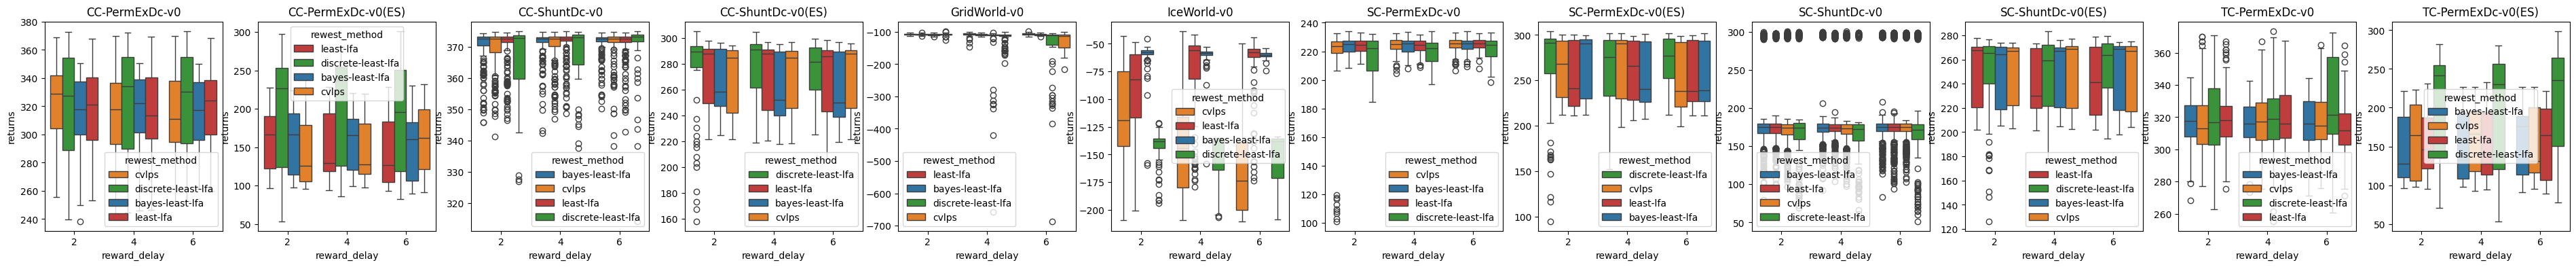

In [58]:
returns_per_est_method(df_proc_result)

## Point of Estimation

In [59]:
df_proc_result.iloc[0]

task_id                            96f79801-06e2-4a08-8b37-38335ce43073
env_name                                                 TC-PermExDc-v0
env_args              {'reward_fn': 'pos-enf', 'penalty_gamma': 1.0,...
control_feats_spec                                           tiles(t:3)
rewest_method                                                 least-lfa
rewest_args           {'attempt_estimation_episode': 50, 'feats_spec...
reward_delay                                                          6
num_episodes                                                       1000
use_bias                                                          False
epochs                                                                1
turn                                                                  1
control_type                                                     Torque
returns                                                      307.532973
solver_state                              {'solution_found_step'

In [60]:
def returns_per_estimation_point(df_input: pd.DataFrame):
    df_ref = copy.copy(df_input[["env_name", "rewest_method", "reward_delay", "returns", "solver_state"]])
    df_ref["solution_found_step"] = df_proc_result["solver_state"].apply(
        lambda dt: dt["solution_found_step"]
    )
    del df_ref["solver_state"]
    return df_ref

In [61]:
df_returns_estp = returns_per_estimation_point(df_proc_result)

In [62]:
df_returns_estp

,env_name,rewest_method,reward_delay,returns,solution_found_step
0,TC-PermExDc-v0,least-lfa,6,307.532973,5880
1,SC-ShuntDc-v0(ES),least-lfa,4,208.117394,431
2,SC-ShuntDc-v0,bayes-least-lfa,2,147.629250,6795
3,TC-PermExDc-v0(ES),bayes-least-lfa,2,125.928602,111
4,SC-ShuntDc-v0,least-lfa,2,179.536387,7088
...,...,...,...,...,...
18715,CC-ShuntDc-v0,bayes-least-lfa,2,361.209302,6518
18716,CC-PermExDc-v0,least-lfa,4,314.175926,10646
18717,GridWorld-v0,discrete-least-lfa,2,-109.851400,9978
18718,GridWorld-v0,least-lfa,4,-110.198600,10600


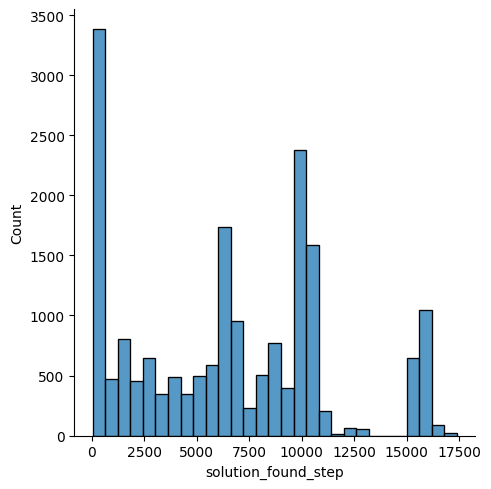

In [63]:
sns.displot(df_returns_estp["solution_found_step"])

In [64]:
def plot_estimation_step(df_input, env_name: str, pallete=METHOD_PALLETE):
    df_plot = df_input[df_input["env_name"] == env_name]
    sns.relplot(data=df_plot, x="solution_found_step", y="returns", col="reward_delay", hue="rewest_method", kind="scatter", palette=pallete)

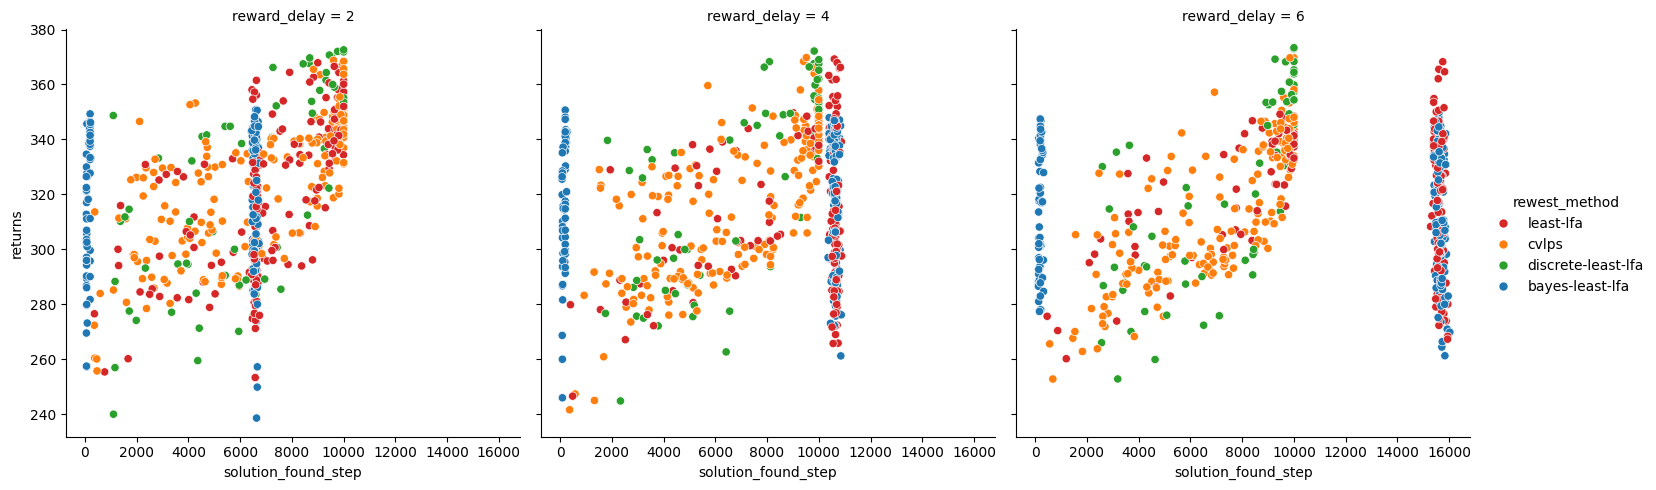

In [65]:
plot_estimation_step(df_returns_estp, env_name="CC-PermExDc-v0")

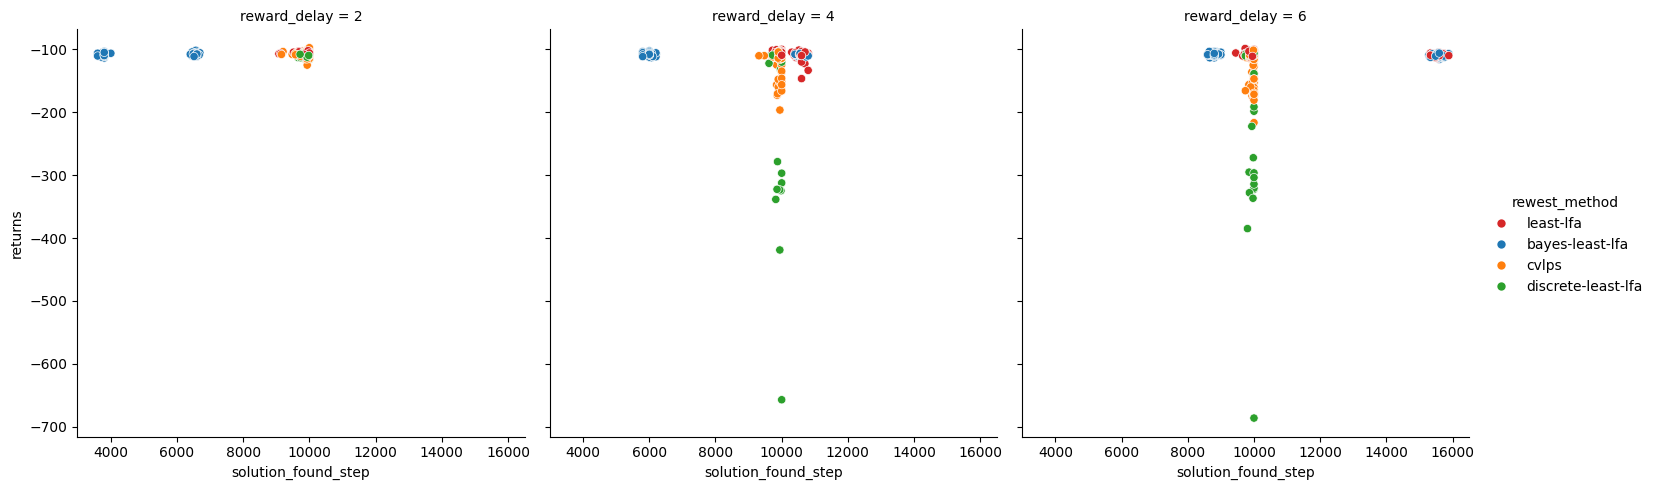

In [66]:
plot_estimation_step(df_returns_estp, env_name="GridWorld-v0")

In [67]:
FEAT_SPEC_PALLETE = {
    key: palette for key, palette in zip(
        sorted(df_est_encodings_and_buffer["rewest_feats_spec"].unique()),
        sns.color_palette()
    )
}

In [68]:
def returns_per_config_est_episode(df_input: pd.DataFrame, pallete = FEAT_SPEC_PALLETE):
    # Aggregates across delays
    df_ref = df_input[["env_name", "rewest_method", "returns", "rewest_buffer_mult", "rewest_feats_spec"]]
    df_ref = copy.copy(df_ref).sort_values(["env_name", "rewest_method", "rewest_feats_spec", "rewest_buffer_mult"])
    
    envs = sorted(df_ref["env_name"].unique())
    algorithms = sorted(df_ref["rewest_method"].unique())
    nrows, ncols = 1, len(algorithms)

    for env in envs:
        fig, axes = plt.subplots(
            nrows=nrows, ncols=ncols,
            figsize=(4*ncols, 4*nrows),
            sharey=True
        )                    
        
        for ax, algo in zip(axes.flatten(), algorithms):
            df_env = df_ref[(df_ref["env_name"] == env) & (df_ref["rewest_method"] == algo)]
            sns.boxplot(
                data=df_env, x="rewest_buffer_mult", y="returns", 
                hue="rewest_feats_spec", ax=ax,
                palette=pallete
            )
            ax.set_title(f"{env}/{algo}")

Questions
 - Is scaling the best encoding for GEM envrionments?
 - What is the right data point?
 - What the best configs for each estimation method?
 - What are the differences between estimation methods?

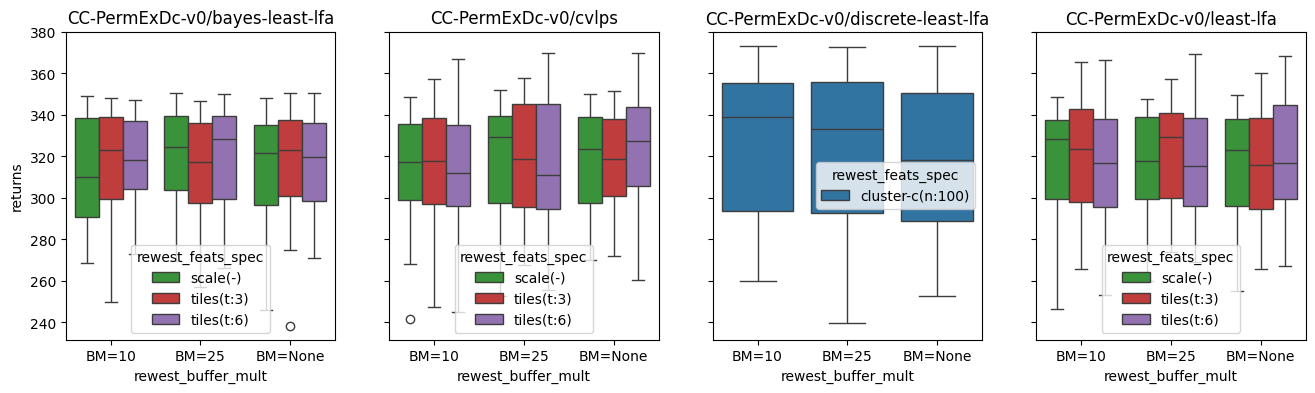

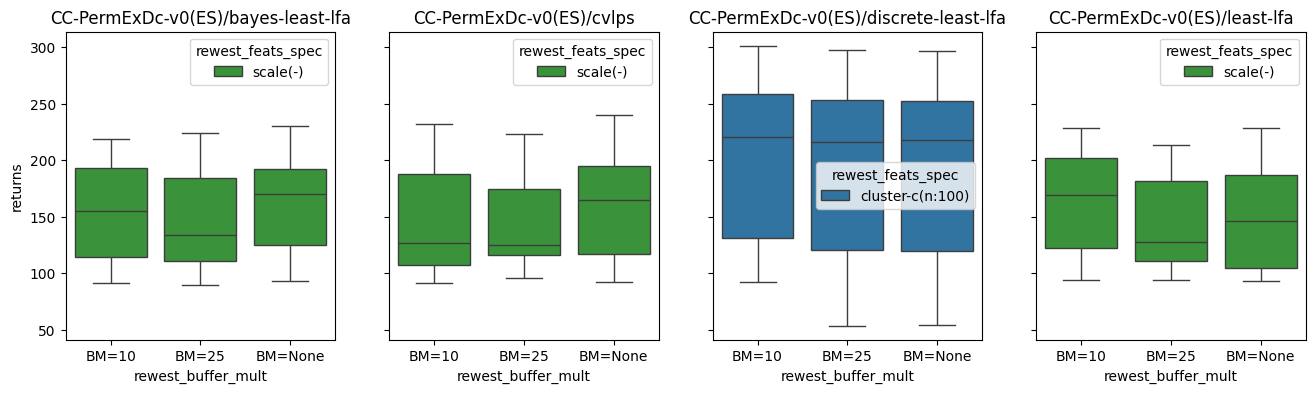

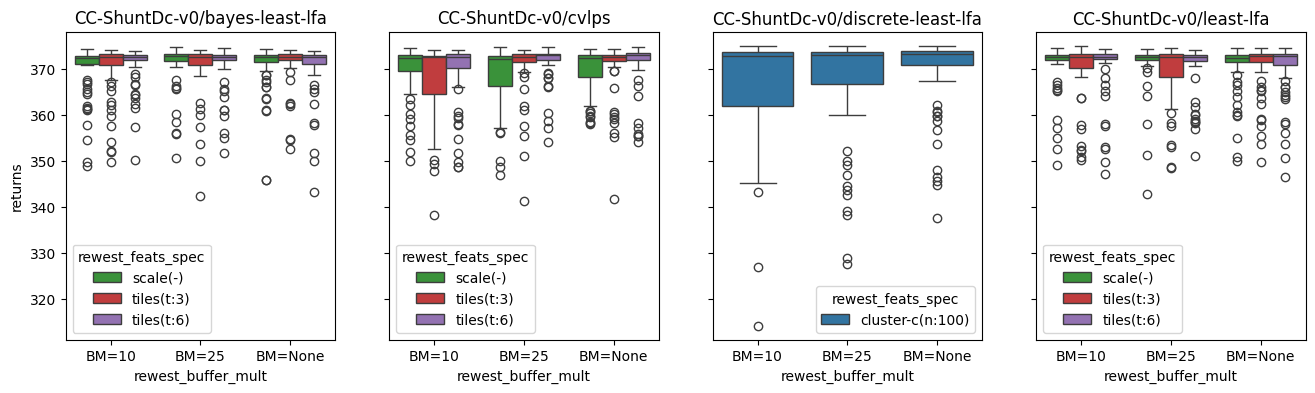

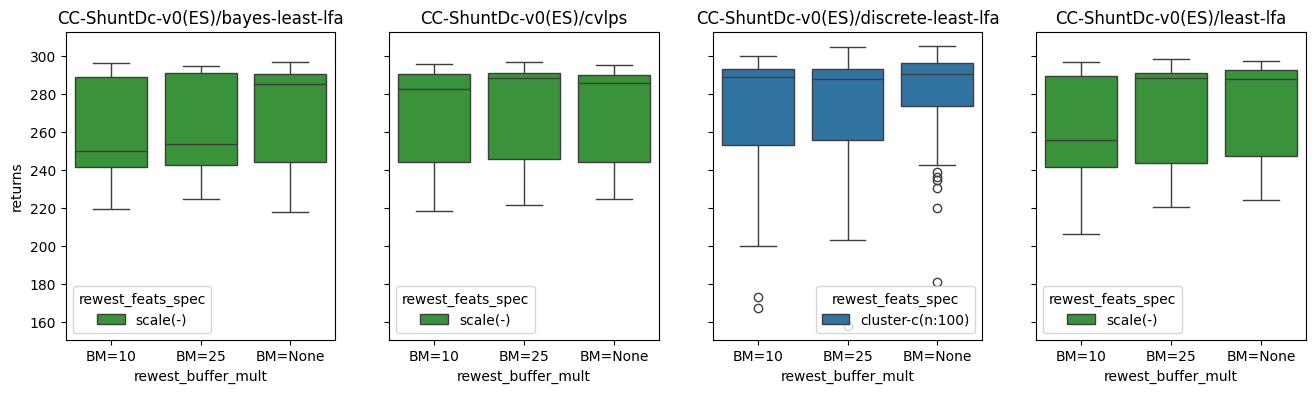

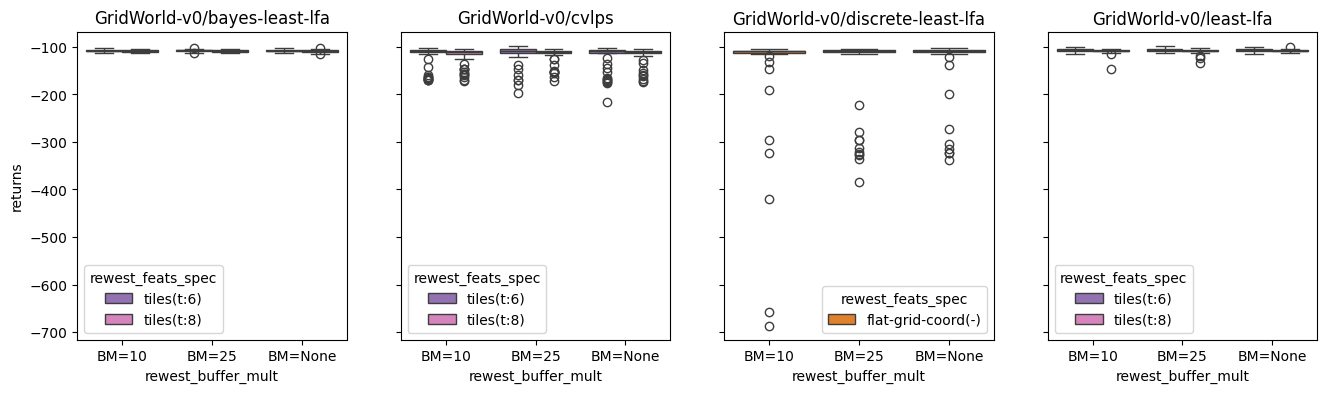

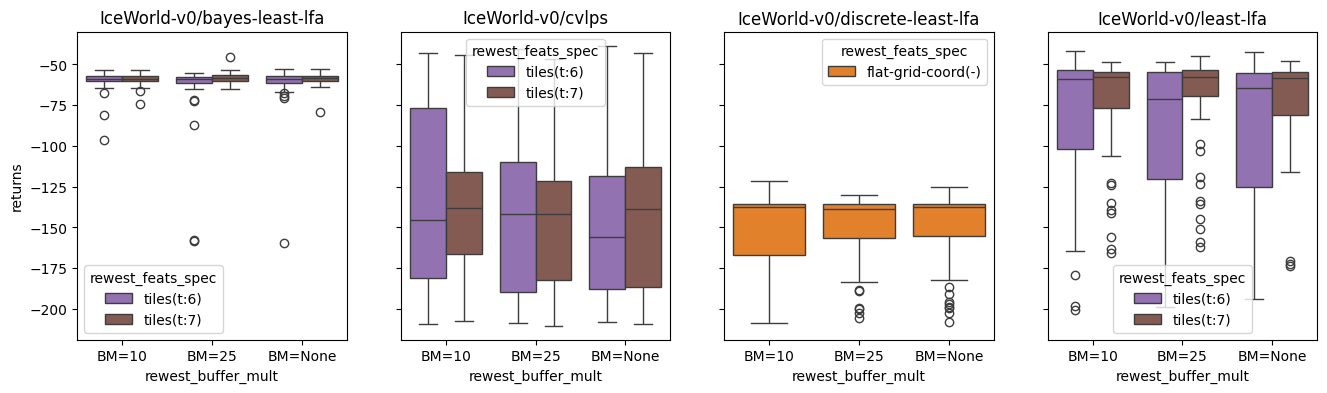

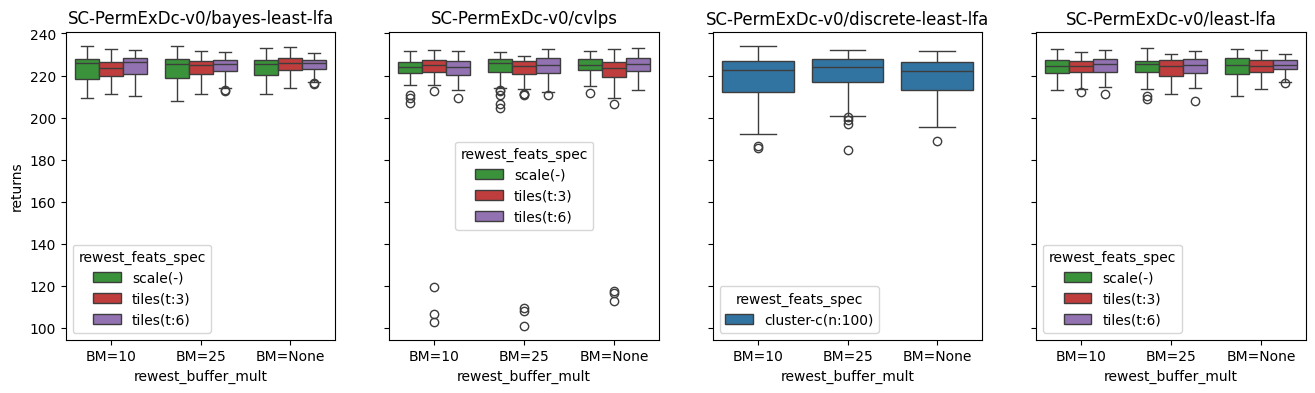

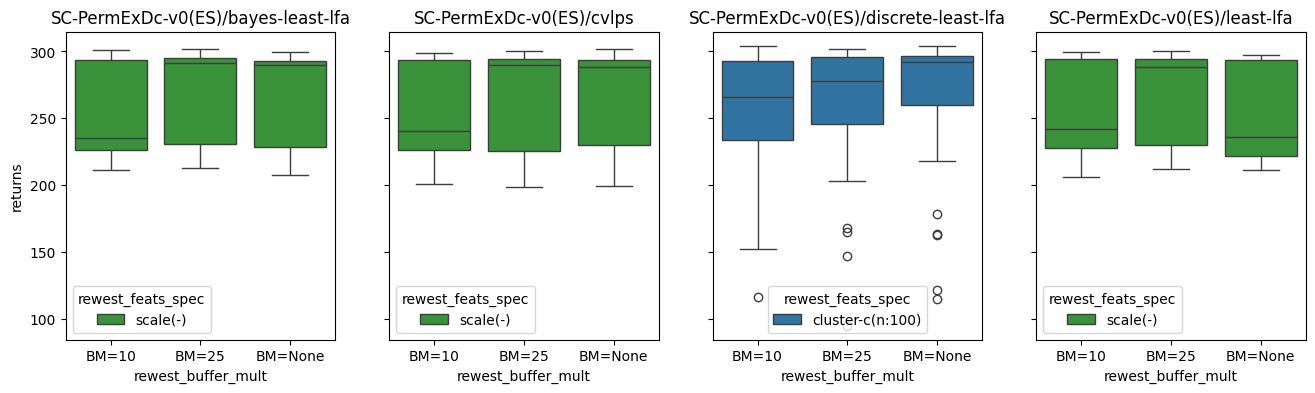

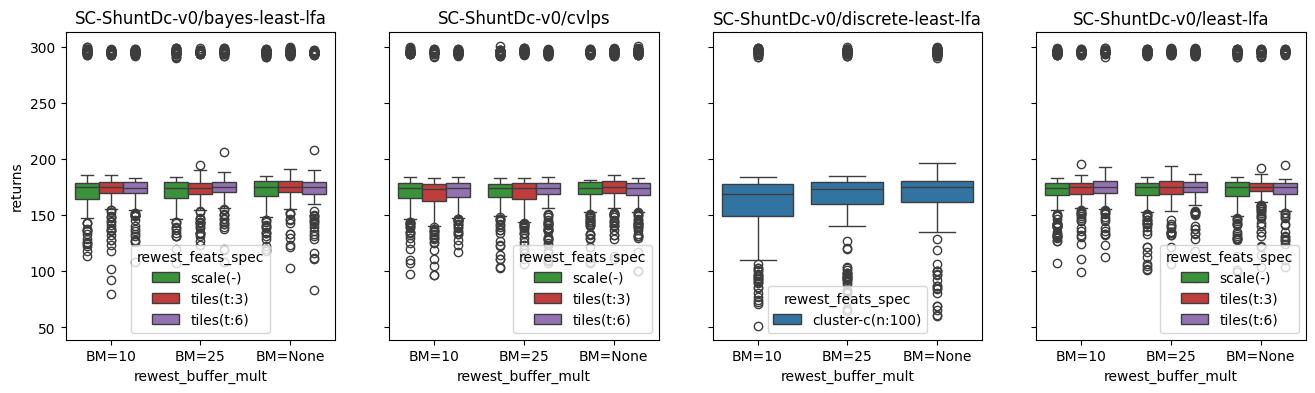

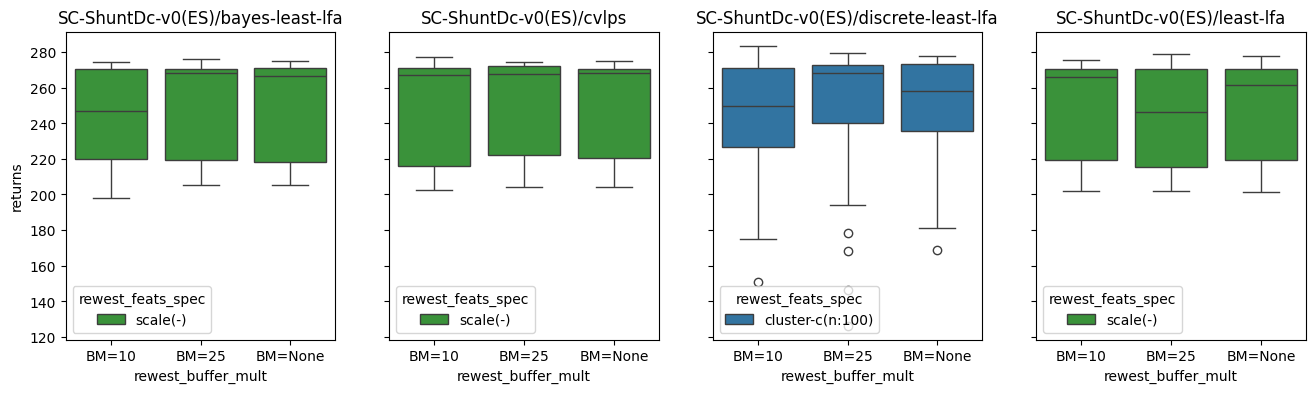

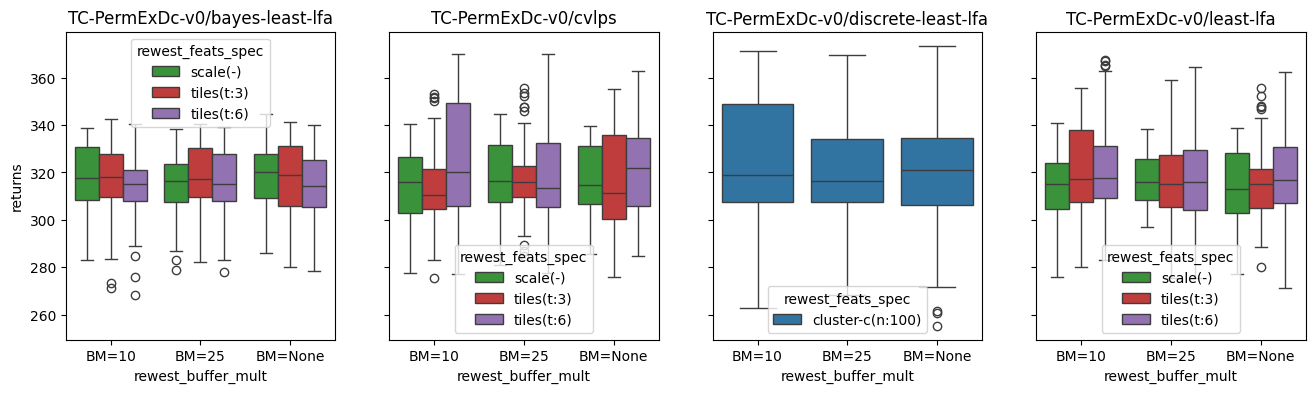

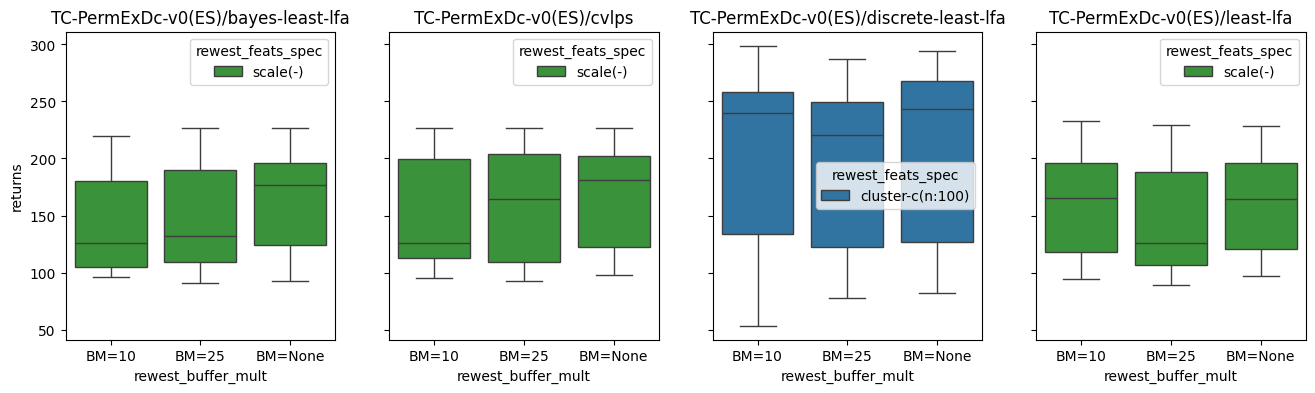

In [69]:
returns_per_config_est_episode(df_est_encodings_and_buffer)